# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
# Análise dados
import pandas as pd
import numpy as np

# Plotagem
import seaborn as sns
import matplotlib.pyplot as plt

# Modelagem
import statsmodels.formula.api as smf

# Métricas
from sklearn.metrics import roc_curve
from sklearn import metrics
from scipy.stats import ks_2samp

In [2]:
# Importando os dados
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
# Verificando as variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


# Exercício 1

Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [4]:
def calcula_indicadores(
        explicativa: str,
        resposta: str,
        df: pd.DataFrame,
        categoria: bool = False,
        bins: int = 5,
    ) -> pd.DataFrame:
    '''
    Função que calcula indices de bivariadas categórias e resposta
    :param explicativa (str): Variável independente;
    :param resposta (str): Variável dependente;
    :param df (pd.DataFrame): DataFrame contendo o conjunto de dados
    :param categoria (bool) = False: Informa se a variável independente 
                                        é categorica;
    :param bins (int) = 5: Número de categorias para divisão da variável 
                            independente;
    :return tab (pd.DataFrame): DataFrame com os indices;
    '''
    if categoria:
        df[explicativa+"_cat"] = pd.cut(x=df[explicativa], bins=bins)
        explicativa += "_cat"
        
    tab = pd.crosstab(df[explicativa], df[resposta], margins=True)
    odds_all = tab.iloc[2, 1] / tab.iloc[2, 0]
    tab = (
        tab.assign(prob = tab["All"] / tab.loc['All', 'All'])               # Probabilidade de ser mulher ou homem no conjunto de dados
        .assign(risck_event = tab[1]/tab['All'])                            # Risco do evento (probabilidede) de uma mulher ou de um homem estar doente
        .assign(odds = tab[1] / tab[0])                                     # Chance (odds) de uma mulher ou de um homem estar doente
        .assign(odds_ratio = (tab.iloc[:, 1] / tab.iloc[:, 0])/(odds_all))  # A razão entre as chances de estar doente para mulheres e homens
        .assign(log_odds = np.log(tab.loc[:, 1] / tab.loc[:, 0]))           # Logaritmo da chance
        .assign(woe = np.log(                                               # Logaritmo da razão da chance ou Weigth of Evidence
            (tab.iloc[:, 1] / tab.iloc[:, 0])/(odds_all)
        ))
    )
    tab['log_odds'] = [x if x != np.inf*-1 else np.nan for x in tab['log_odds']]
    tab['woe'] = [x if x != np.inf*-1 else np.nan for x in tab['woe']]
    
    print(f"Flag negativo: {tab.loc['All', 0]}")
    print(f"Flag positivo: {tab.loc['All', 1]}")
    print(f"Total: {tab.loc['All', 'All']}")

    return tab

In [5]:
# Instanciando tabela com os indicadores para sexo
kwards = {
            "explicativa": "sex",
            "resposta": 'flag_doente',
            "df":df
}
sex = calcula_indicadores(**kwards)
sex

Flag negativo: 164
Flag positivo: 139
Total: 303


flag_doente,0,1,All,prob,risck_event,odds,odds_ratio,log_odds,woe
sex,,,,,,,,,
0.0,72,25,97,0.320132,0.257732,0.347222,0.409672,-1.057790,-0.892398
1.0,92,114,206,0.679868,0.553398,1.239130,1.461996,0.214410,0.379802
All,164,139,303,1.000000,0.458746,0.847561,1.000000,-0.165392,0.000000


In [6]:
# Instanciando tabela com os indicadores para cp
kwards = {
            "explicativa": "cp",
            "resposta": 'flag_doente',
            "df":df
}
cp = calcula_indicadores(**kwards)
cp

Flag negativo: 164
Flag positivo: 139
Total: 303


flag_doente,0,1,All,prob,risck_event,odds,odds_ratio,log_odds,woe
cp,,,,,,,,,
1.0,16,7,23,0.075908,0.304348,0.437500,1.652778,-0.826679,0.502457
2.0,41,9,50,0.165017,0.180000,0.219512,0.829268,-1.516347,-0.187212
3.0,68,18,86,0.283828,0.209302,0.264706,1.000000,-1.329136,0.000000
4.0,39,105,144,0.475248,0.729167,2.692308,10.170940,0.990399,2.319535
All,164,139,303,1.000000,0.458746,0.847561,3.201897,-0.165392,1.163743


In [7]:
# Instanciando tabela com os indicadores para restecg
kwards = {
            "explicativa": "restecg",
            "resposta": 'flag_doente',
            "df":df
}
restecg = calcula_indicadores(**kwards)
restecg

Flag negativo: 164
Flag positivo: 139
Total: 303


flag_doente,0,1,All,prob,risck_event,odds,odds_ratio,log_odds,woe
restecg,,,,,,,,,
0.0,95,56,151,0.498350,0.370861,0.589474,0.501053,-0.528525,-0.691044
1.0,1,3,4,0.013201,0.750000,3.000000,2.550000,1.098612,0.936093
2.0,68,80,148,0.488449,0.540541,1.176471,1.000000,0.162519,0.000000
All,164,139,303,1.000000,0.458746,0.847561,0.720427,-0.165392,-0.327911


In [8]:
# Instanciando tabela com os indicadores para slope
kwards = {
            "explicativa": "slope",
            "resposta": 'flag_doente',
            "df":df
}
slope = calcula_indicadores(**kwards)
slope

Flag negativo: 164
Flag positivo: 139
Total: 303


flag_doente,0,1,All,prob,risck_event,odds,odds_ratio,log_odds,woe
slope,,,,,,,,,
1.0,106,36,142,0.468647,0.253521,0.339623,0.254717,-1.079920,-1.367602
2.0,49,91,140,0.462046,0.650000,1.857143,1.392857,0.619039,0.331357
3.0,9,12,21,0.069307,0.571429,1.333333,1.000000,0.287682,0.000000
All,164,139,303,1.000000,0.458746,0.847561,0.635671,-0.165392,-0.453075


## Conclusão:

- Duas das variáveis com melhor distribuição entre os casos de doença dos pacientes são a `restecg` e a `slope`, sendo que essas poderiam ser mais explicativas, por terem riscos mais bem definidos.

---

# Exercício 2

Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  

Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [9]:
# Instanciando tabela com os indicadores para age
kwards = {
            "explicativa": "age",
            "resposta": 'flag_doente',
            "categoria": True,
            "df":df
}
age = calcula_indicadores(**kwards)
age

Flag negativo: 164
Flag positivo: 139
Total: 303


flag_doente,0,1,All,prob,risck_event,odds,odds_ratio,log_odds,woe
age_cat,,,,,,,,,
"(28.952, 38.6]",8,3,11,0.036304,0.272727,0.375000,0.512195,-0.980829,-0.669050
"(38.6, 48.2]",50,21,71,0.234323,0.295775,0.420000,0.573659,-0.867501,-0.555721
"(48.2, 57.8]",56,41,97,0.320132,0.422680,0.732143,1.000000,-0.311780,0.000000
"(57.8, 67.4]",40,67,107,0.353135,0.626168,1.675000,2.287805,0.515813,0.827593
"(67.4, 77.0]",10,7,17,0.056106,0.411765,0.700000,0.956098,-0.356675,-0.044895
All,164,139,303,1.000000,0.458746,0.847561,1.157644,-0.165392,0.146387


In [10]:
# Instanciando tabela com os indicadores para age
kwards = {
            "explicativa": "age",
            "resposta": 'flag_doente',
            "categoria": True,
            "bins": 3,
            "df":df
}
age = calcula_indicadores(**kwards)
age

Flag negativo: 164
Flag positivo: 139
Total: 303


flag_doente,0,1,All,prob,risck_event,odds,odds_ratio,log_odds,woe
age_cat,,,,,,,,,
"(28.952, 45.0]",47,16,63,0.207921,0.253968,0.340426,0.312823,-1.077559,-1.162116
"(45.0, 61.0]",83,86,169,0.557756,0.508876,1.036145,0.952133,0.035507,-0.049051
"(61.0, 77.0]",34,37,71,0.234323,0.521127,1.088235,1.000000,0.084557,0.000000
All,164,139,303,1.000000,0.458746,0.847561,0.778840,-0.165392,-0.249950


In [11]:
# Instanciando tabela com os indicadores para trestbps
kwards = {
            "explicativa": "trestbps",
            "resposta": 'flag_doente',
            "categoria": True,
            "df":df
}
trestbps = calcula_indicadores(**kwards)
trestbps

Flag negativo: 164
Flag positivo: 139
Total: 303


flag_doente,0,1,All,prob,risck_event,odds,odds_ratio,log_odds,woe
trestbps_cat,,,,,,,,,
"(93.894, 115.2]",32,20,52,0.171617,0.384615,0.625000,0.705128,-0.470004,-0.349376
"(115.2, 136.4]",79,62,141,0.465347,0.439716,0.784810,0.885427,-0.242313,-0.121685
"(136.4, 157.6]",44,39,83,0.273927,0.469880,0.886364,1.000000,-0.120628,0.000000
"(157.6, 178.8]",8,14,22,0.072607,0.636364,1.750000,1.974359,0.559616,0.680244
"(178.8, 200.0]",1,4,5,0.016502,0.800000,4.000000,4.512821,1.386294,1.506922
All,164,139,303,1.000000,0.458746,0.847561,0.956223,-0.165392,-0.044765


## Conclusão:

- A função anterior pode ser usada para a definição dos indices das variáveis quantitativas;
- O melhor indice para fazer essa verificação de importância é o odds;

---

# Exercício 3

Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [12]:
# Verificando as variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   age           303 non-null    float64 
 1   sex           303 non-null    float64 
 2   cp            303 non-null    float64 
 3   trestbps      303 non-null    float64 
 4   chol          303 non-null    float64 
 5   fbs           303 non-null    float64 
 6   restecg       303 non-null    float64 
 7   thalach       303 non-null    float64 
 8   exang         303 non-null    float64 
 9   oldpeak       303 non-null    float64 
 10  slope         303 non-null    float64 
 11  ca            303 non-null    object  
 12  thal          303 non-null    object  
 13  num           303 non-null    int64   
 14  flag_doente   303 non-null    int64   
 15  age_cat       303 non-null    category
 16  trestbps_cat  303 non-null    category
dtypes: category(2), float64(11), int64(2), object(2)
memor

In [13]:
'''
Descrição dos indices obtidos no modelo
    coef            -> Estimativa pontual do coeficiente beta para a variável
    std err         -> Erro padrão dado o coeficiente
    z               -> Estatística Z que é o coef/std err
    P>|z|           -> Probabilidade de o coef ser zero
    [0.025	0.975]  -> Intervalo de confiança para 95%
'''

'\nDescrição dos indices obtidos no modelo\n    coef            -> Estimativa pontual do coeficiente beta para a variável\n    std err         -> Erro padrão dado o coeficiente\n    z               -> Estatística Z que é o coef/std err\n    P>|z|           -> Probabilidade de o coef ser zero\n    [0.025\t0.975]  -> Intervalo de confiança para 95%\n'

In [14]:
modelo = "flag_doente ~ age + C(sex) + C(cp) + trestbps"

reglog = smf.logit(
    modelo,
    data=df
).fit()

reglog.summary()

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Fri, 31 May 2024   Pseudo R-squ.:                  0.3097
Time:                        18:46:11   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -8.3407      1.621     -5.145      0.000     -11.518      -5.163
C(sex)[T.1.0]     1.8094      0.353      5.130      0.000       1.118       2.501
C(cp)[T.2.0]     -0.0617      0.636     -0.097      0.923      -1.309       1.186
C(cp)[T.3.0]      0.0715      0.573      0.125      0.901      -1.051       1.194
C(cp)[T.4.0]      2.4789      0.553      4.485      0.000       1.396       3.562
age               0.0567      0.018      3.120      0.002       0.021       0.092
trestbps          0.0193      0.009      2.261      0.024       0.003       0.036
=================================================================================
"""

In [15]:
# Assin em relação a angina
1/np.exp(2.4)

0.09071795328941251

## Conclusão:

- As variáveis `age` e `trestbps` são significativas. 

  - `trestbps` aumento de 0.0193 no log da chance de doença para cada aumento no mm Hg da pressão sanguínea em repouso;
  - `age` aumento de 0.0567 no log da chance de doença para cada ano incremental de vida;

- Já para `sex` o log da chance de doença é de 1.8 para homem em relação a mulher. Homens tem uma maior chance de estar doente do que as mulheres.
- Para `cp` (tipo de dor) no caso de estar doente:
  - angina atípica é menor, não significativo, que na angina típica
  - dor não angina é maior, não significativo, que na angina típica
  - assintomático é maior, significativo, que na angina típica

---

# Exercício 4

Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [16]:
# Probabilidade de predição
df['predito'] = reglog.predict(df)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,age_cat,trestbps_cat,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,"(61.0, 77.0]","(136.4, 157.6]",0.458229
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,"(61.0, 77.0]","(157.6, 178.8]",0.944123
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,"(61.0, 77.0]","(115.2, 136.4]",0.886566
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,"(28.952, 45.0]","(115.2, 136.4]",0.134929
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,"(28.952, 45.0]","(115.2, 136.4]",0.027278


In [17]:
# Categorizando as probabilidades de doença preditas
cat_pred = pd.qcut(df['predito'], 5, duplicates='drop')
cat_pred.value_counts().sort_index()

predito
(0.0131, 0.143]    62
(0.143, 0.287]     59
(0.287, 0.586]     62
(0.586, 0.822]     59
(0.822, 0.944]     61
Name: count, dtype: int64

In [18]:
# Agrupando as categorias de probailidade de predição 
group_reg = df.groupby(cat_pred)

# Obtendo a frequncia absoluta
qualid = group_reg[['flag_doente']].count().rename(columns = {'flag_doente': 'contagem'})
qualid

C:\Users\gfsil\AppData\Local\Temp\ipykernel_12260\886227259.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_reg = df.groupby(cat_pred)


,contagem
predito,
"(0.0131, 0.143]",62
"(0.143, 0.287]",59
"(0.287, 0.586]",62
"(0.586, 0.822]",59
"(0.822, 0.944]",61


In [19]:
# Obtendo as probabilidades preditas médias
qualid['predito'] = group_reg['predito'].mean()
qualid

,contagem,predito
predito,,
"(0.0131, 0.143]",62,0.072008
"(0.143, 0.287]",59,0.209626
"(0.287, 0.586]",62,0.435175
"(0.586, 0.822]",59,0.708861
"(0.822, 0.944]",61,0.874819


In [20]:
# Obtendo a taxa de eventos, com a média de pacientes doentes por grupo
qualid['pct_sobrev'] = group_reg['flag_doente'].mean()
qualid

,contagem,predito,pct_sobrev
predito,,,
"(0.0131, 0.143]",62,0.072008,0.080645
"(0.143, 0.287]",59,0.209626,0.152542
"(0.287, 0.586]",62,0.435175,0.483871
"(0.586, 0.822]",59,0.708861,0.762712
"(0.822, 0.944]",61,0.874819,0.819672


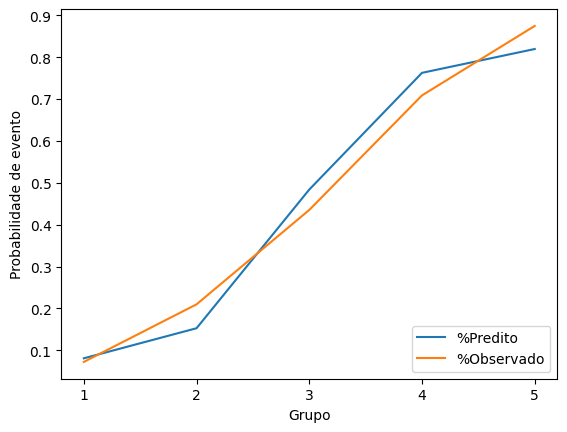

In [21]:
# Plotando a probabilidade de doença por grupo nos observados e preditos 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['pct_sobrev'].plot(label='%Predito')
ax = qualid['predito'].plot(label='%Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')
plt.show()

## Conclusão:

- O modelo parece calibrado. A probabilidade de doença varia pouco do predito para o observado, quando comparado aos grupos, o que mostra uma modelo eficiente.

---

# Exercício 5

Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

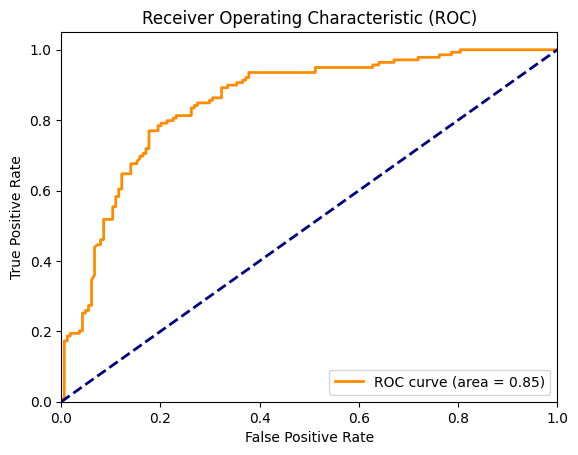

In [22]:
# Plotando a curva ROC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

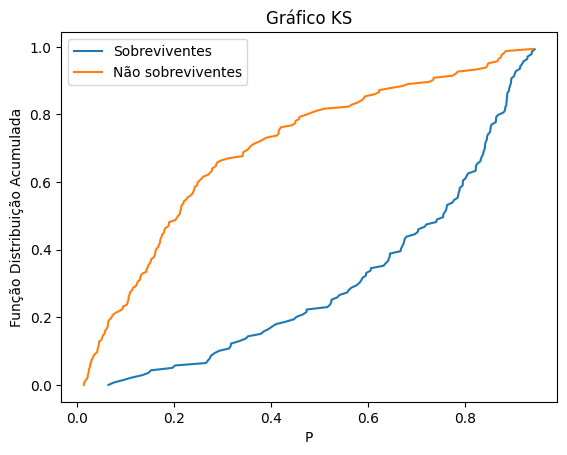

In [23]:
# Plotagem da métrica KS (Kolmogorov-Smirnov)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df.loc[df['flag_doente']==1,'predito']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Sobreviventes')

score_pop2 = df.loc[df['flag_doente']!=1,'predito']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Não sobreviventes')
ax.legend()

plt.title("Gráfico KS")
ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')
plt.show()

#### Indicadores

In [24]:
acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 79.54%
KS: 59.30% 
AUC: 85.19% 
GINI: 70.39%


## Conclusão:

- A curva *ROC* apresentação um valor interessante de 85,19% do positivo verdadeiro em relação ao falso;
- Já o *KS* (Kolmogorov-Smirnov) de 59,3% mostra uma evolução rápida do não sobrevivente em relação ao sobrevivente, o que é esperado.
- Com *acurácia* sendo usada como benchmark de acerto.

---

# Exercício 6

Tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.
Avalie as características do seu modelo (calibragem e acurácia).

In [25]:
# Inserindo novas variáveis
modelo = "flag_doente ~ age + C(sex) + exang + slope + oldpeak + C(ca) + C(thal)"

reglog = smf.logit(
    modelo,
    data=df
).fit()

reglog.summary()

Optimization terminated successfully.
         Current function value: 0.377299
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      290
Method:                           MLE   Df Model:                           12
Date:                Fri, 31 May 2024   Pseudo R-squ.:                  0.4530
Time:                        18:46:14   Log-Likelihood:                -114.32
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 5.138e-34
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -4.4931      1.257     -3.573      0.000      -6.958      -2.028
C(sex)[T.1.0]      0.8062      0.418      1.929      0.054      -0.013       1.625
C(ca)[T.1.0]       1.7957      0.429      4.185      0.000       0.955       2.637
C(ca)[T.2.0]       2.6860      0.609      4.410      0.000       1.492       3.880
C(ca)[T.3.0]       2.3969      0.768      3.120      0.002       0.891       3.902
C(ca)[T.?]        -0.5096      1.431     -0.356      0.722      -3.313       2.294
C(thal)[T.6.0]     0.5896      0.707      0.834      0.404      -0.796       1.976
C(thal)[T.7.0]     1.6882      0.379      4.454      0.000       0.945       2.431
C(thal)[T.?]       1.9277      1.936      0.995      0.319      -1.868       5.723
age                0.0063      0.020      0.308      0.758      -0.034       0.046
exang              1.4795      0.371      3.988      0.000       0.752       2.207
slope              0.5993      0.329      1.819      0.069      -0.046       1.245
oldpeak            0.3858      0.203      1.904      0.057      -0.011       0.783
==================================================================================
"""

In [26]:
# Verificanco as previsões
df['predito'] = reglog.predict(df)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,age_cat,trestbps_cat,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,"(61.0, 77.0]","(136.4, 157.6]",0.496203
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,"(61.0, 77.0]","(157.6, 178.8]",0.915972
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,"(61.0, 77.0]","(115.2, 136.4]",0.991761
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,"(28.952, 45.0]","(115.2, 136.4]",0.424200
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,"(28.952, 45.0]","(115.2, 136.4]",0.043299


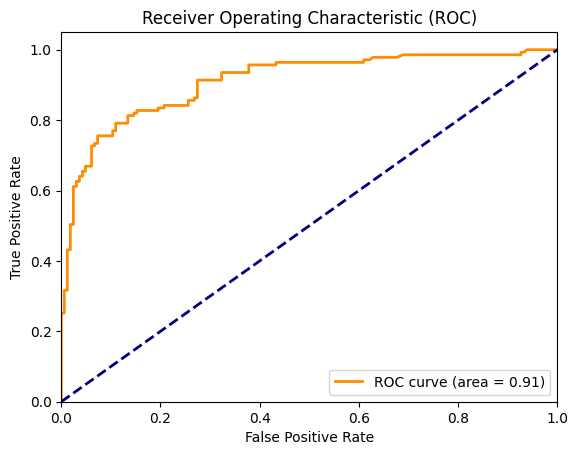

In [27]:
# Plotando a curva ROC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

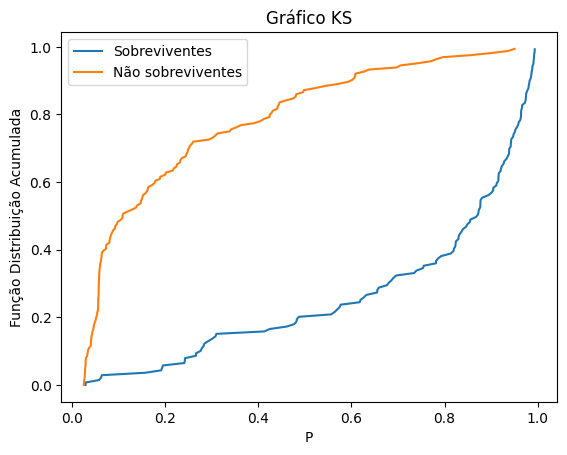

In [28]:
# Plotagem da métrica KS (Kolmogorov-Smirnov)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df.loc[df['flag_doente']==1,'predito']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Sobreviventes')

score_pop2 = df.loc[df['flag_doente']!=1,'predito']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Não sobreviventes')
ax.legend()

plt.title("Gráfico KS")
ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')
plt.show()

#### Indicadores

In [29]:
acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 83.83%
KS: 68.22% 
AUC: 90.97% 
GINI: 81.94%


## Conclusão:

- Com as novas variáveis, todas as métricas analisadas foram melhoradas.